In [106]:
import tensorflow as tf
import keras
import retina
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

In [107]:
df = pd.read_csv(retina.filesys.TRAINING_DATA_CSV_PATH, index_col=False)
labels = df["label"]
df = df.drop(columns=["label"])
df = df.loc[:,tuple(filter(lambda x: x.startswith("texture"), df.columns))]
df

,texture-1,texture-2,texture-3,texture-4,texture-5,texture-6,texture-7,texture-8,texture-9,texture-10,...,texture-481,texture-482,texture-483,texture-484,texture-485,texture-486,texture-487,texture-488,texture-489,texture-490
0,0.003813,0.001765,0.004873,0.000424,0.002754,0.000565,0.000212,0.001907,0.001200,0.002895,...,0.007627,0.001695,0.001624,0.000918,0.001200,0.000494,0.000353,0.000706,0.000636,0.005155
1,0.006638,0.001130,0.002683,0.000494,0.001412,0.000706,0.000282,0.001554,0.001342,0.004166,...,0.009392,0.001412,0.001836,0.000636,0.001130,0.000706,0.000706,0.000424,0.000918,0.003248
2,0.004308,0.003037,0.005720,0.000282,0.002189,0.000636,0.000282,0.001342,0.000424,0.002189,...,0.007627,0.002189,0.001907,0.000494,0.001695,0.000777,0.000777,0.000847,0.000424,0.003672
3,0.003884,0.000636,0.002330,0.000000,0.001765,0.003813,0.000282,0.005649,0.000353,0.001695,...,0.004449,0.000918,0.002895,0.000282,0.001412,0.002189,0.000212,0.002260,0.001342,0.004449
4,0.005367,0.000918,0.002683,0.000424,0.001765,0.001624,0.000141,0.002048,0.001342,0.004096,...,0.005791,0.002966,0.004449,0.000212,0.002542,0.000494,0.000282,0.000918,0.000353,0.002401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,0.006779,0.001765,0.002048,0.000565,0.000989,0.001059,0.000424,0.001342,0.001059,0.004378,...,0.006567,0.001907,0.000847,0.000424,0.001765,0.000424,0.000282,0.001554,0.001624,0.005014
408,0.006144,0.002472,0.003178,0.000565,0.001836,0.000565,0.000424,0.001412,0.000706,0.003107,...,0.006991,0.001271,0.001695,0.000565,0.001765,0.000424,0.000494,0.001342,0.000847,0.005014
409,0.005084,0.001977,0.003107,0.000424,0.001765,0.000565,0.000282,0.001765,0.001624,0.003813,...,0.006355,0.000847,0.001200,0.000706,0.001200,0.000777,0.000071,0.002048,0.001907,0.005296
410,0.006426,0.001836,0.001765,0.000212,0.001200,0.000918,0.000636,0.001695,0.001412,0.004308,...,0.006709,0.001554,0.001342,0.000847,0.001342,0.000777,0.000353,0.001200,0.001130,0.005155


In [108]:
dataset = tf.data.Dataset.from_tensor_slices((df, labels))
train_dataset, test_dataset = keras.utils.split_dataset(dataset, shuffle=True, seed=42, left_size=0.7)
train_dataset, validation_dataset = keras.utils.split_dataset(train_dataset, shuffle=True, seed=42, left_size=0.7)

train_dataset: tf.data.Dataset = train_dataset.repeat(5).shuffle(100).batch(16)
test_dataset: tf.data.Dataset = test_dataset.batch(16)
validation_dataset: tf.data.Dataset = validation_dataset.batch(16)

dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(490,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [109]:
model = keras.Sequential([
  keras.layers.Input(shape=dataset.element_spec[0].shape),
  keras.layers.Dense(128, activation="relu"),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dense(6, activation="softmax"),
])

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001), # type: ignore
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"],
)

In [110]:
history = model.fit(
  train_dataset, epochs=30,
  validation_data=validation_dataset,
)

Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2522 - loss: 1.7674 - val_accuracy: 0.2093 - val_loss: 1.8378
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2590 - loss: 1.7294 - val_accuracy: 0.2093 - val_loss: 1.8317
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2691 - loss: 1.7238 - val_accuracy: 0.2093 - val_loss: 1.8152
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3074 - loss: 1.7048 - val_accuracy: 0.2558 - val_loss: 1.7932
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3427 - loss: 1.6685 - val_accuracy: 0.3605 - val_loss: 1.7505
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4296 - loss: 1.5810 - val_accuracy: 0.3488 - val_loss: 1.6602
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4455 - loss: 1.4694 - val_accuracy: 0.3605 - val_loss: 1.6421
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5063 - loss: 1.3384 - val_accuracy: 0.4070 - val_loss

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\Davin Tristan\AppData\Local\Temp\ipykernel_25180\2105622587.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


{'Angry': {'precision': 0.6666666666666666,
  'recall': 0.5555555555555556,
  'f1-score': 0.6060606060606061,
  'support': 18.0},
 'Disgusted': {'precision': 0.2631578947368421,
  'recall': 0.3125,
  'f1-score': 0.2857142857142857,
  'support': 16.0},
 'Happy': {'precision': 0.8275862068965517,
  'recall': 0.8,
  'f1-score': 0.8135593220338984,
  'support': 30.0},
 'Neutral': {'precision': 0.5238095238095238,
  'recall': 0.5789473684210527,
  'f1-score': 0.55,
  'support': 19.0},
 'Sad': {'precision': 0.6363636363636364,
  'recall': 0.7,
  'f1-score': 0.6666666666666666,
  'support': 20.0},
 'Surprised': {'precision': 0.7222222222222222,
  'recall': 0.6190476190476191,
  'f1-score': 0.6666666666666666,
  'support': 21.0},
 'accuracy': 0.6209677419354839,
 'macro avg': {'precision': 0.6066343584492405,
  'recall': 0.5943417571707046,
  'f1-score': 0.5981112578570206,
  'support': 124.0},
 'weighted avg': {'precision': 0.6361647812016642,
  'recall': 0.6209677419354839,
  'f1-score': 0.6

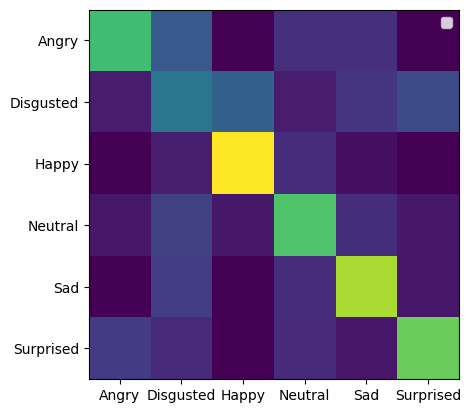

In [111]:
from typing import cast

confidences = model.predict(test_dataset)
predictions = np.argmax(confidences, axis=1)

labels = cast(list[int], list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
target_names = retina.face.FacialExpressionLabel.target_names()

cmat = sklearn.metrics.confusion_matrix(labels, predictions, normalize="true")

plt.imshow(cmat)
plt.legend()
plt.xticks(range(len(target_names)), target_names)
plt.yticks(range(len(target_names)), target_names)

sklearn.metrics.classification_report(labels, predictions, output_dict=True, target_names=target_names)

In [112]:
model.save(retina.filesys.EXPRESSION_RECOGNITION_MODEL_PATH)

C:\Users\Davin Tristan\AppData\Local\Temp\ipykernel_25180\469801421.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  accuracy_fig.show()


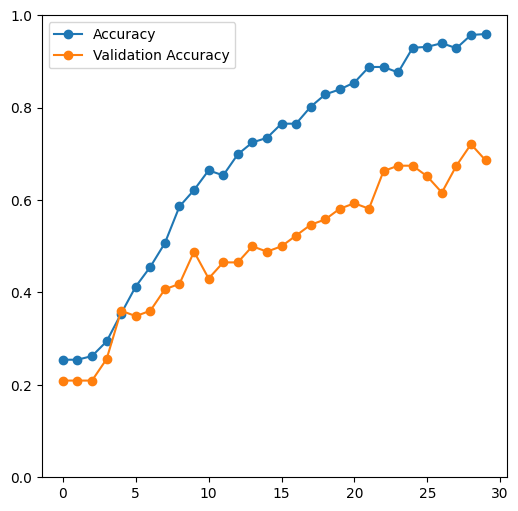

In [113]:
accuracy_fig = plt.figure(figsize=(6,6))
ax = accuracy_fig.add_subplot()
ax.plot(history.history["accuracy"], label="Accuracy", marker='o')
ax.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='o')
ax.legend()
ax.set_ylim(0, 1)
accuracy_fig.show()